In [1]:
import numpy as np
from scipy.io import loadmat
from scipy.optimize import minimize
import pickle
from sklearn.svm import SVC

In [11]:
import sklearn as sk

In [40]:
import seaborn as sn
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
def preprocess():
    """ 
     Input:
     Although this function doesn't have any input, you are required to load
     the MNIST data set from file 'mnist_all.mat'.

     Output:
     train_data: matrix of training set. Each row of train_data contains 
       feature vector of a image
     train_label: vector of label corresponding to each image in the training
       set
     validation_data: matrix of training set. Each row of validation_data 
       contains feature vector of a image
     validation_label: vector of label corresponding to each image in the 
       training set
     test_data: matrix of training set. Each row of test_data contains 
       feature vector of a image
     test_label: vector of label corresponding to each image in the testing
       set
    """

    mat = loadmat('mnist_all.mat')  # loads the MAT object as a Dictionary

    n_feature = mat.get("train1").shape[1]
    n_sample = 0
    for i in range(10):
        n_sample = n_sample + mat.get("train" + str(i)).shape[0]
    n_validation = 1000
    n_train = n_sample - 10 * n_validation

    # Construct validation data
    validation_data = np.zeros((10 * n_validation, n_feature))
    for i in range(10):
        validation_data[i * n_validation:(i + 1) * n_validation, :] = mat.get("train" + str(i))[0:n_validation, :]

    # Construct validation label
    validation_label = np.ones((10 * n_validation, 1))
    for i in range(10):
        validation_label[i * n_validation:(i + 1) * n_validation, :] = i * np.ones((n_validation, 1))

    # Construct training data and label
    train_data = np.zeros((n_train, n_feature))
    train_label = np.zeros((n_train, 1))
    temp = 0
    for i in range(10):
        size_i = mat.get("train" + str(i)).shape[0]
        train_data[temp:temp + size_i - n_validation, :] = mat.get("train" + str(i))[n_validation:size_i, :]
        train_label[temp:temp + size_i - n_validation, :] = i * np.ones((size_i - n_validation, 1))
        temp = temp + size_i - n_validation

    # Construct test data and label
    n_test = 0
    for i in range(10):
        n_test = n_test + mat.get("test" + str(i)).shape[0]
    test_data = np.zeros((n_test, n_feature))
    test_label = np.zeros((n_test, 1))
    temp = 0
    for i in range(10):
        size_i = mat.get("test" + str(i)).shape[0]
        test_data[temp:temp + size_i, :] = mat.get("test" + str(i))
        test_label[temp:temp + size_i, :] = i * np.ones((size_i, 1))
        temp = temp + size_i

    # Delete features which don't provide any useful information for classifiers
    sigma = np.std(train_data, axis=0)
    index = np.array([])
    for i in range(n_feature):
        if (sigma[i] > 0.001):
            index = np.append(index, [i])
    train_data = train_data[:, index.astype(int)]
    validation_data = validation_data[:, index.astype(int)]
    test_data = test_data[:, index.astype(int)]

    # Scale data to 0 and 1
    train_data /= 255.0
    validation_data /= 255.0
    test_data /= 255.0

    return train_data, train_label, validation_data, validation_label, test_data, test_label


In [3]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

In [4]:
def blrObjFunction(initialWeights, *args):
    """
    blrObjFunction computes 2-class Logistic Regression error function and
    its gradient.

    Input:
        initialWeights: the weight vector (w_k) of size (D + 1) x 1 
        train_data: the data matrix of size N x D
        labeli: the label vector (y_k) of size N x 1 where each entry can be either 0 or 1 representing the label of corresponding feature vector

    Output: 
        error: the scalar value of error function of 2-class logistic regression
        error_grad: the vector of size (D+1) x 1 representing the gradient of
                    error function
    """
    train_data, labeli = args
    
    n_data = train_data.shape[0]
    n_features = train_data.shape[1]
    error = 0
    error_grad = np.zeros((n_features + 1, 1))
    w = initialWeights

    ##################
    # YOUR CODE HERE #
    ##################
    # HINT: Do not forget to add the bias term to your input data
    w = w.reshape((n_features+1,1))
    
    x = np.hstack((np.ones((n_data,1)),train_data))
    Z = sigmoid(np.dot(x,w))

    error = labeli * np.log(Z) + (1.0 - labeli) * np.log(1.0 - Z)
    error = -np.sum(error)

    error_grad = (Z - labeli) * x
    error_grad = np.sum(error_grad, axis=0)

    return error, error_grad

In [5]:
def blrPredict(W, data):
    """
     blrObjFunction predicts the label of data given the data and parameter W 
     of Logistic Regression
     
     Input:
         W: the matrix of weight of size (D + 1) x 10. Each column is the weight 
         vector of a Logistic Regression classifier.
         X: the data matrix of size N x D
         
     Output: 
         label: vector of size N x 1 representing the predicted label of 
         corresponding feature vector given in data matrix

    """ 
    label = np.zeros((data.shape[0], 1))
    ##################
    # YOUR CODE HERE #
    ##################
    # HINT: Do not forget to add the bias term to your input data
    
    
    
    n_data = data.shape[0]
    data = np.hstack([np.ones(n_data).reshape(n_data,1),data]) 

    label = sigmoid(np.dot(data,W)) 
    
    label = np.argmax(label,axis=1)
    label = label.reshape(n_data,1)

    return label


In [52]:
def mlrObjFunction(params, *args):
    """
    mlrObjFunction computes multi-class Logistic Regression error function and
    its gradient.

    Input:
        initialWeights: the weight vector of size (D + 1) x 1
        train_data: the data matrix of size N x D
        labeli: the label vector of size N x 1 where each entry can be either 0 or 1
                representing the label of corresponding feature vector

    Output:
        error: the scalar value of error function of multi-class logistic regression
        error_grad: the vector of size (D+1) x 10 representing the gradient of
                    error function
    """

    train_data, Y = args
    n_data = train_data.shape[0]
    n_feature = train_data.shape[1]
    initialWeights_b=params.reshape(716,10)
    
    #error_grad = 0
    #error_grad = np.zeros((n_feature + 1, n_class))

    ##################
    # YOUR CODE HERE #
    ##################
    # HINT: Do not forget to add the bias term to your input data
    
    train_data=np.column_stack((np.ones(train_data.shape[0]),train_data))
    
    a=np.exp(np.dot(train_data,initialWeights_b))
        
    b=np.sum(a,axis=1)
    b=b.reshape(b.shape[0],1)
    
    theta=a/b
    
    #print(theta.shape)
    error= - (np.sum(np.sum(Y*np.log(theta))))
    
    error_grad = np.dot(train_data.transpose(),(theta-Y))
    
    error_grad=error_grad.ravel()
    
    return error, error_grad

In [53]:
def mlrPredict(W, data):
    """
     mlrObjFunction predicts the label of data given the data and parameter W
     of Logistic Regression

     Input:
         W: the matrix of weight of size (D + 1) x 10. Each column is the weight
         vector of a Logistic Regression classifier.
         X: the data matrix of size N x D

     Output:
         label: vector of size N x 1 representing the predicted label of
         corresponding feature vector given in data matrix

    """
    #label = np.zeros((data.shape[0], 1))
    data=np.column_stack((np.ones(data.shape[0]),data))
    
    a=np.dot(data,W_b)
    
    a=np.exp(a)
    
    b=np.sum(a,axis=1)
    
    b=b.reshape(b.shape[0],1)
    
    theta=a/b
    
    label=np.argmax(theta,axis=1)
    
    label=label.reshape(data.shape[0],1)
    
    ##################
    # YOUR CODE HERE #
    ##################
    # HINT: Do not forget to add the bias term to your input data

    return label

In [8]:
"""
Script for Logistic Regression
"""
train_data, train_label, validation_data, validation_label, test_data, test_label = preprocess()

# number of classes
n_class = 10

# number of training samples
n_train = train_data.shape[0]

# number of features
n_feature = train_data.shape[1]

Y = np.zeros((n_train, n_class))
for i in range(n_class):
    Y[:, i] = (train_label == i).astype(int).ravel()

# Logistic Regression with Gradient Descent
W = np.zeros((n_feature + 1, n_class))
initialWeights = np.zeros((n_feature + 1, 1))
opts = {'maxiter': 100}
for i in range(n_class):
    labeli = Y[:, i].reshape(n_train, 1)
    args = (train_data, labeli)
    nn_params = minimize(blrObjFunction, initialWeights, jac=True, args=args, method='CG', options=opts)
    W[:, i] = nn_params.x.reshape((n_feature + 1,))

# Find the accuracy on Training Dataset
predicted_label = blrPredict(W, train_data)
print('\n Training set Accuracy:' + str(100 * np.mean((predicted_label == train_label).astype(float))) + '%')

# Find the accuracy on Validation Dataset
predicted_label = blrPredict(W, validation_data)
print('\n Validation set Accuracy:' + str(100 * np.mean((predicted_label == validation_label).astype(float))) + '%')

# Find the accuracy on Testing Dataset
predicted_label = blrPredict(W, test_data)
print('\n Testing set Accuracy:' + str(100 * np.mean((predicted_label == test_label).astype(float))) + '%')

/Users/anish/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log
/Users/anish/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in multiply
/Users/anish/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
/Users/anish/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log
/Users/anish/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in multiply



 Training set Accuracy:84.936%

 Validation set Accuracy:83.72%

 Testing set Accuracy:84.17%


In [17]:
conf_matrix=sk.metrics.confusion_matrix(test_label,predicted_label)

In [18]:
conf_matrix

array([[ 963,    0,    1,    2,    1,    4,    5,    3,    0,    1],
       [   0, 1123,    4,    1,    0,    1,    5,    1,    0,    0],
       [   9,   11,  946,   19,   12,    4,   14,   13,    0,    4],
       [   4,    1,   23,  927,    2,   22,    4,   13,    0,   14],
       [   1,    2,    5,    3,  920,    0,    9,    2,    1,   39],
       [  11,    3,    3,   42,   13,  777,   22,   10,    0,   11],
       [   9,    4,    8,    2,    4,   20,  910,    1,    0,    0],
       [   2,   11,   23,    5,    8,    2,    1,  948,    0,   28],
       [  33,   37,  149,  197,   52,  260,   46,   23,    1,  176],
       [  10,    8,    1,   17,   35,   13,    1,   22,    0,  902]])

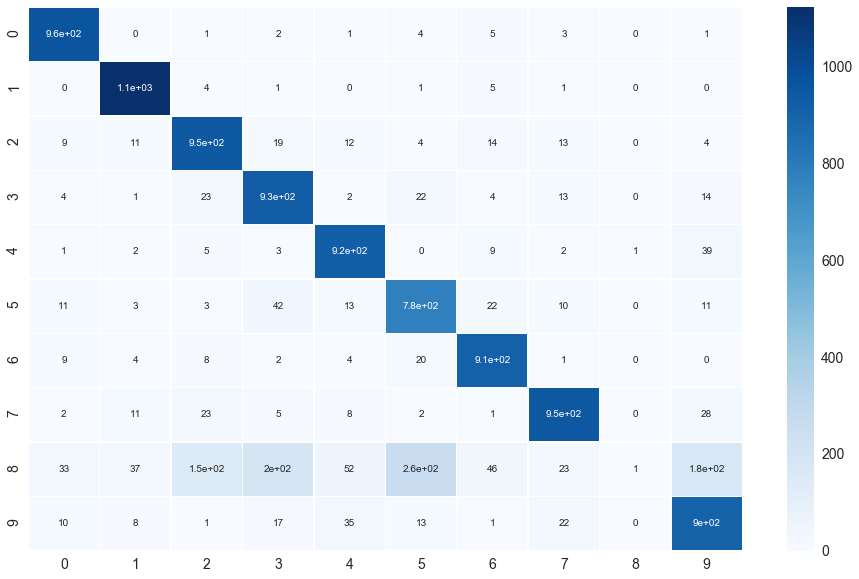

In [56]:
df_cm = pd.DataFrame(conf_matrix, range(10),range(10))
sn.set(font_scale=1.4)#for label size
plt.figure(figsize = (16,10))
sn.heatmap(df_cm, annot=True,annot_kws={"size": 10},linewidths=.5, cmap="Blues")

In [ ]:
"""
Script for Support Vector Machine
"""

print('\n\n--------------SVM-------------------\n\n')
##################
# YOUR CODE HERE #
##################

f1 = open('params.pickle', 'wb') 
pickle.dump(W, f1) 
f1.close()



# Linear kernel
print('SVM with linear kernel')
classifier = SVC(kernel='linear')
classifier.fit(train_data, train_label.flatten())
print('\n Training set Accuracy:' + str(100*classifier.score(train_data, train_label)) + '%')
print('\n Validation set Accuracy:' + str(100*classifier.score(validation_data, validation_label)) + '%')
print('\n Testing set Accuracy:' + str(100*classifier.score(test_data, test_label)) + '%')


# Radial basis function with gamma = 1
print('\n\n SVM with radial basis function, gamma = 1')
classifier = SVC(kernel='rbf', gamma=1.0)
classifier.fit(train_data, train_label.flatten())
print('\n Training set Accuracy:' + str(100*classifier.score(train_data, train_label)) + '%')
print('\n Validation set Accuracy:' + str(100*classifier.score(validation_data, validation_label)) + '%')
print('\n Testing set Accuracy:' + str(100*classifier.score(test_data, test_label)) + '%')


# Radial basis function with gamma = 0
print('\n\n SVM with radial basis function, gamma = 0')
classifier = SVC(kernel='rbf')
classifier.fit(train_data, train_label.flatten())
print('\n Training set Accuracy:' + str(100*classifier.score(train_data, train_label)) + '%')
print('\n Validation set Accuracy:' + str(100*classifier.score(validation_data, validation_label)) + '%')
print('\n Testing set Accuracy:' + str(100*classifier.score(test_data, test_label)) + '%')


print('\n\n RBF, gamma = default, varying C values 1,10,20,...100 SVM \n')
cvalues = [1]
for i in cvalues:
    classifier = SVC(C=i,kernel='rbf')
    classifier.fit(train_data,train_label)
    predicted_values = classifier.predict(train_data);
    print('C =' + str(i)+'\n')
    print('\n Training set Accuracy:' + str(100*np.mean((predicted_values == train_label).astype(float))) + '%')
    predicted_values = classifier.predict(validation_data);
    print('\n Validation set Accuracy:' + str(100*np.mean((predicted_values == validation_label).astype(float))) + '%')
    predicted_values = classifier.predict(test_data);
    print('\n Testing set Accuracy:' + str(100*np.mean((predicted_values == test_label).astype(float))) + '%')


In [54]:
"""
Script for Extra Credit Part
"""
# FOR EXTRA CREDIT ONLY
W_b = np.zeros((n_feature + 1, n_class))
initialWeights_b = np.zeros((n_feature + 1, n_class))
opts_b = {'maxiter': 100}

args_b = (train_data, Y)
nn_params = minimize(mlrObjFunction, initialWeights_b, jac=True, args=args_b, method='CG', options=opts_b)
W_b = nn_params.x.reshape((n_feature + 1, n_class))

# Find the accuracy on Training Dataset
predicted_label_b = mlrPredict(W_b, train_data)
print('\n Training set Accuracy:' + str(100 * np.mean((predicted_label_b == train_label).astype(float))) + '%')

# Find the accuracy on Validation Dataset
predicted_label_b = mlrPredict(W_b, validation_data)
print('\n Validation set Accuracy:' + str(100 * np.mean((predicted_label_b == validation_label).astype(float))) + '%')

# Find the accuracy on Testing Dataset
predicted_label_b = mlrPredict(W_b, test_data)
print('\n Testing set Accuracy:' + str(100 * np.mean((predicted_label_b == test_label).astype(float))) + '%')



 Training set Accuracy:93.11%

 Validation set Accuracy:92.54%

 Testing set Accuracy:92.55%
